In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from pathlib import Path
import yaml
import torch
import numpy as np
from scipy.special import erf
import os
import torch.nn as nn
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import torchvision

import matplotlib.pyplot as plt


## Attention mechanism
- first build up the attention mechanism

In [2]:
# ---------------------------------------------------------------------------------------

# utils

#

def drop_path(
    
    x,  
    drop_prob: float = 0.,
    training: bool = False,
    scale_by_keep: bool = True
             
):

    if drop_prob == 0. or not training:
        
        return x
    
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    
    if keep_prob > 0.0 and scale_by_keep:
        
        random_tensor.div_(keep_prob)
    
    return x * random_tensor


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    
    Deactivates some of the block's weights. Improves the effectivness of training
    
    """
    
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        
        return f'drop_prob={round(self.drop_prob,3):0.3f}'
    

# ---------------------------------------------------------------------------------------

# attention mechanisms

#

class Attention(nn.Module):
    """
    Attention is all you need
    
    """
    
    def __init__(self, dim, heads, dropout):
        super().__init__()
        
        self.heads = heads
        head_dim = dim // heads
        self.scale = head_dim ** -0.5
        self.attn = None

        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        
        return self

    def forward(self, x, mask=None):
        
        B, N, C = x.shape
        
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, C // self.heads)
            .permute(2, 0, 3, 1, 4)
        )
        
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x, attn


class FeedForward(nn.Module):
    
    def __init__(self, dim, hidden_dim, dropout, out_dim=None):
        super().__init__()
        
        # first fully connected layer
        self.fc1 = nn.Linear(dim, hidden_dim)
        
        # applies Guassian Error Linear units function
        self.act = nn.GELU()
        
        if out_dim is None:
            
            out_dim = dim
        
        # second fully connected layer
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        
        # dropout
        self.drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        
        return self

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        
        return x


class Block(nn.Module):
    """
    creates a single block representing the main part of the
    encoder
    
    """
    
    def __init__(self, dim, heads, mlp_dim, dropout, drop_path):
        super().__init__()
        
        # add & normalise layer 1
        self.norm1 = nn.LayerNorm(dim)
        
        # add & normalise layer 1
        self.norm2 = nn.LayerNorm(dim)
        
        # the multi-head attention layer
        self.attn = Attention(dim, heads, dropout)
        
        # feed forward layer
        self.mlp = FeedForward(dim, mlp_dim, dropout)
        
        # dropping of stoichiastic depth sample
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x, mask=None, return_attention=False):
        
        # first do the attention mechanism
        y, attn = self.attn(self.norm1(x), mask)
        
        if return_attention:
            
            return attn
        
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x

## Components of the Transformer
### Encoder
- contains the attention mechanism

### Decoder
- takes the output of the encoder + input signal and classifications
- two layers of attention mechanism


In [43]:
# ---------------------------------------------------------------------------------------

# utils

#

def trunc_normal(tensor: torch.Tensor,
                  mean: float=0.,
                  std: float=1.,
                  a: float=-2., 
                  b: float=2.) -> torch.Tensor:
    
    def norm_cdf(x):
        
        # Computes standard normal cumulative distribution function
        return (1. + erf(x / np.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * np.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def init_weights(m):

    if isinstance(m, nn.Linear):
        
        trunc_normal(m.weight, std=0.02)
        
        if isinstance(m, nn.Linear) and m.bias is not None:
            
            nn.init.constant_(m.bias, 0)
    
    elif isinstance(m, nn.LayerNorm):
        
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)
        
# ---------------------------------------------------------------------------------------

# encoder + tools

#

def resize_pos_embed(posemb, grid_old_shape, grid_new_shape, num_extra_tokens):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    
    posemb_tok, posemb_grid = (
        posemb[:, :num_extra_tokens],
        posemb[0, num_extra_tokens:],
    )
    
    if grid_old_shape is None:
        
        gs_old_h = int(math.sqrt(len(posemb_grid)))
        gs_old_w = gs_old_h
    
    else:
        
        gs_old_h, gs_old_w = grid_old_shape

    gs_h, gs_w = grid_new_shape
    posemb_grid = posemb_grid.reshape(1, gs_old_h, gs_old_w, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(gs_h, gs_w), mode="bilinear")
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_h * gs_w, -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    
    return posemb


class PatchEmbedding(nn.Module):
    
    def __init__(self, image_size, patch_size, embed_dim, channels):
        super().__init__()

        self.image_size = image_size
        
#         if image_size[0] % patch_size[0] != 0 or image_size[1] % patch_size[1] != 0:
            
#             raise ValueError("[Error] image dimensions must be divisible by the patch size")
        
        self.grid_size = image_size[0] // patch_size[0], image_size[1] // patch_size[0]
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, im):
        
        B, C, H, W = im.shape
        x = self.proj(im).flatten(2).transpose(1, 2)
        
        return x


class VisionTransformer(nn.Module):
    
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        n_cls,
        dropout=0.1,
        drop_path_rate=0.0,
        distilled=False,
        channels=3,
    ):
        super().__init__()
        
        # patch embedding routine
        self.patch_embed = PatchEmbedding(
            image_size,
            patch_size,
            d_model,
            channels,
        )
        
        # parameters
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.n_cls = n_cls

        # class and positional tokens
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.distilled = distilled
        
        if self.distilled:
            
            self.dist_token = nn.Parameter(torch.zeros(1, 1, d_model))
            
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 2, d_model)
            )
            
            self.head_dist = nn.Linear(d_model, n_cls)
        
        else:
            
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 1, d_model)
            )

        # transformer blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        
        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff, dropout, dpr[i]) for i in range(n_layers)]
        )

        # output head
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_cls)

        trunc_normal(self.pos_embed, std=0.02)
        trunc_normal(self.cls_token, std=0.02)
        
        if self.distilled:
            
            trunc_normal(self.dist_token, std=0.02)
        
        self.pre_logits = nn.Identity()

        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        
        return {"pos_embed", "cls_token", "dist_token"}

    def forward(self, im, return_features=False):
        
        B, _, H, W = im.shape
        PS = self.patch_size

        x = self.patch_embed(im)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        if self.distilled:
            
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        
        else:
            
            x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.pos_embed
        num_extra_tokens = 1 + self.distilled
        
        if x.shape[1] != pos_embed.shape[1]:
            
            pos_embed = resize_pos_embed(
                pos_embed,
                self.patch_embed.grid_size,
                (H // PS[0], W // PS[0]),
                num_extra_tokens,
            )
        
        x = x + pos_embed
        x = self.dropout(x)

        for blk in self.blocks:
            
            x = blk(x)
        
        x = self.norm(x)

        if return_features:
            return x

        if self.distilled:
            
            x, x_dist = x[:, 0], x[:, 1]
            x = self.head(x)
            x_dist = self.head_dist(x_dist)
            x = (x + x_dist) / 2
        
        else:
            
            x = x[:, 0]
            x = self.head(x)
        
        return x

    def get_attention_map(self, im, layer_id):
        
        if layer_id >= self.n_layers or layer_id < 0:
            
            raise ValueError(
                f"Provided layer_id: {layer_id} is not valid. 0 <= {layer_id} < {self.n_layers}."
            )
        
        B, _, H, W = im.shape
        PS = self.patch_size

        x = self.patch_embed(im)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        if self.distilled:
            
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        
        else:
            
            x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.pos_embed
        num_extra_tokens = 1 + self.distilled
        
        if x.shape[1] != pos_embed.shape[1]:
            
            pos_embed = resize_pos_embed(
                pos_embed,
                self.patch_embed.grid_size,
                (H // PS, W // PS),
                num_extra_tokens,
            )
        
        x = x + pos_embed

        for i, blk in enumerate(self.blocks):
            
            if i < layer_id:
                
                x = blk(x)
            
            else:
                
                return blk(x, return_attention=True)


# ---------------------------------------------------------------------------------------

# dencoder + tools

#

class MaskTransformer(nn.Module):
    def __init__(
        self,
        n_cls,
        patch_size,
        d_encoder,
        n_layers,
        n_heads,
        d_model,
        d_ff,
        drop_path_rate,
        dropout,
    ):
        super().__init__()
        self.d_encoder = d_encoder
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.n_cls = n_cls
        self.d_model = d_model
        self.d_ff = d_ff
        self.scale = d_model ** -0.5

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        
        # do the attention blocks
        self.blocks = nn.ModuleList(
            
            [Block(d_model, n_heads, d_ff, dropout, dpr[i]) for i in range(n_layers)]
        
        )

        self.cls_emb = nn.Parameter(torch.randn(1, n_cls, d_model))
        self.proj_dec = nn.Linear(d_encoder, d_model)

        self.proj_patch = nn.Parameter(self.scale * torch.randn(d_model, d_model))
        self.proj_classes = nn.Parameter(self.scale * torch.randn(d_model, d_model))

        self.decoder_norm = nn.LayerNorm(d_model)
        self.mask_norm = nn.LayerNorm(n_cls)

        self.apply(init_weights)
        trunc_normal(self.cls_emb, std=0.02)

    @torch.jit.ignore
    def no_weight_decay(self):
        
        return {"cls_emb"}

    def forward(self, x, im_size):
        
        H, W = im_size
        GS = H // self.patch_size

        x = self.proj_dec(x)
        cls_emb = self.cls_emb.expand(x.size(0), -1, -1)
        x = torch.cat((x, cls_emb), 1)
        
        for blk in self.blocks:
            
            x = blk(x)
        
        x = self.decoder_norm(x)

        patches, cls_seg_feat = x[:, : -self.n_cls], x[:, -self.n_cls :]
        patches = patches @ self.proj_patch
        cls_seg_feat = cls_seg_feat @ self.proj_classes

        patches = patches / patches.norm(dim=-1, keepdim=True)
        cls_seg_feat = cls_seg_feat / cls_seg_feat.norm(dim=-1, keepdim=True)

        masks = patches @ cls_seg_feat.transpose(1, 2)
        masks = self.mask_norm(masks)
        masks = rearrange(masks, "b (h w) n -> b n h w", h=int(GS))

        return masks

    def get_attention_map(self, x, layer_id):
        
        if layer_id >= self.n_layers or layer_id < 0:
            
            raise ValueError(
                f"Provided layer_id: {layer_id} is not valid. 0 <= {layer_id} < {self.n_layers}."
            )
        
        x = self.proj_dec(x)
        cls_emb = self.cls_emb.expand(x.size(0), -1, -1)
        x = torch.cat((x, cls_emb), 1)
        
        for i, blk in enumerate(self.blocks):
            
            if i < layer_id:
                
                x = blk(x)
            
            else:
                
                return blk(x, return_attention=True)

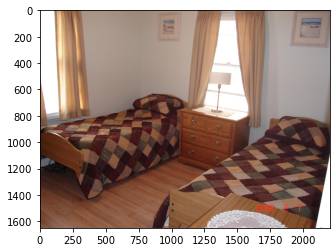

In [44]:
# Define transforms for test
IMG_SIZE = (2200, 1650)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              torchvision.transforms.Resize(IMG_SIZE),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = torchvision.transforms.Compose(transforms)

img = PIL.Image.open(r"C:\Users\johnk\Documents\projects\ubc\notebooks\data\images\consistencyanalysis\original_ade20k\ADE_val_00001122.jpg")
img_tensor = transforms(img).unsqueeze(0).to('cpu')

plt.imshow(img)
plt.show()

In [53]:
def padding(im, patch_size, fill_value=0):
    
    # make the image sizes divisible by patch_size
    H, W = im.size(2), im.size(3)
    pad_h, pad_w = 0, 0
    print(f"\n\n patch size: {patch_size} \n\n")
    if H % patch_size[0] > 0:
        
        pad_h = patch_size - (H % patch_size)
    
    if W % patch_size[1] > 0:
        
        pad_w = patch_size - (W % patch_size)
    
    im_padded = im
    
    if pad_h > 0 or pad_w > 0:
        
        im_padded = F.pad(im, (0, pad_w, 0, pad_h), value=fill_value)
    
    return im_padded


def unpadding(y, target_size):
    H, W = target_size
    H_pad, W_pad = y.size(2), y.size(3)
    # crop predictions on extra pixels coming from padding
    extra_h = H_pad - H
    extra_w = W_pad - W
    if extra_h > 0:
        y = y[:, :, :-extra_h]
    if extra_w > 0:
        y = y[:, :, :, :-extra_w]
    return y

class Segmenter(nn.Module):
    
    def __init__(
        self,
        encoder,
        decoder,
        n_cls,
    ):

        super().__init__()
        self.n_cls = n_cls
        self.patch_size = encoder.patch_size
        self.encoder = encoder
        self.decoder = decoder

    @torch.jit.ignore
    def no_weight_decay(self):
        
        def append_prefix_no_weight_decay(prefix, module):
            
            return set(map(lambda x: prefix + x, module.no_weight_decay()))

        nwd_params = append_prefix_no_weight_decay("encoder.", self.encoder).union(
            append_prefix_no_weight_decay("decoder.", self.decoder)
        )
        
        return nwd_params

    def forward(self, im):

        H_ori, W_ori = im.size(2), im.size(3)
#         im = padding(im, self.patch_size)
        H, W = im.size(2), im.size(3)

        x = self.encoder(im, return_features=True)

        # remove CLS/DIST tokens for decoding
        num_extra_tokens = 1 + self.encoder.distilled
        x = x[:, num_extra_tokens:]

        masks = self.decoder(x, (H, W))

        masks = F.interpolate(masks, size=(H, W), mode="bilinear")
#         masks = unpadding(masks, (H_ori, W_ori))

        return masks

    def get_attention_map_enc(self, im, layer_id):
        return self.encoder.get_attention_map(im, layer_id)

    def get_attention_map_dec(self, im, layer_id):
        x = self.encoder(im, return_features=True)

        # remove CLS/DIST tokens for decoding
        num_extra_tokens = 1 + self.encoder.distilled
        x = x[:, num_extra_tokens:]

        return self.decoder.get_attention_map(x, layer_id)

In [54]:
# ---------------------------------------------------------------------------------------

# bring it all together

#

def create_decoder(encoder, decoder_cfg):
    
    decoder_cfg = decoder_cfg.copy()
    name = decoder_cfg.pop("name")
    decoder_cfg["d_encoder"] = encoder.d_model
    decoder_cfg["patch_size"] = encoder.patch_size

#     if "linear" in name:
        
#         decoder = DecoderLinear(**decoder_cfg)
    
#     elif name == "mask_transformer":
        
    dim = encoder.d_model
    n_heads = dim // 64

    # load up the decoder config
    decoder_cfg["n_heads"] = n_heads
    decoder_cfg["d_model"] = dim
    decoder_cfg["d_ff"] = 4 * dim

    decoder = MaskTransformer(**decoder_cfg)
    
#     else:
        
#         raise ValueError(f"Unknown decoder: {name}")
    
    return decoder


# method for creating the transformer model
def create_segmenter(model_cfg):
    
    model_cfg = model_cfg.copy()
    decoder_cfg = model_cfg.pop("decoder")
    decoder_cfg["n_cls"] = model_cfg["n_cls"]

    encoder = VisionTransformer(**model_cfg)
    decoder = create_decoder(encoder, decoder_cfg)
    model = Segmenter(encoder, decoder, n_cls=model_cfg["n_cls"])

    return model

In [55]:
segmenter_config = {
    
    'image_size': [2000, 1650],
    'patch_size': [110, 110],
    'n_layers': 12,
    'd_model': 300,
    'd_ff': 12,
    'n_heads': 8,
    'n_cls': 1200,
    'dropout': 0.1,
    'drop_path_rate': 0.0,
    'distilled': False,
    'channels': 3,
    'decoder': {
        'name': 'mask_transformer',
        'drop_path_rate': 0.0,
        'dropout': 0.1,
        'n_layers': 2,
    },

}

model = create_segmenter(segmenter_config)

In [56]:
# x = torch.nn.Conv2d(3, 1200, (110, 110), stride=(110, 110))
print(model(img_tensor))

RuntimeError: shape '[1, 301, 3, 8, 37]' is invalid for input of size 270900

In [ ]:
print(x(img_tensor).shape)
c2 = x(img_tensor)[:, 0, 0].detach().numpy()
print(c2.shape)

In [ ]:
plt.plot(c2[0, :], '.')